In [1]:
import os
from functools import partial
import csv
import pandas as pd 
import matplotlib
from collections import defaultdict

import dataset
import evaluate

In [2]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch()

In [3]:
es_client = Elasticsearch(
    "localhost:9200",
    http_auth=["elastic", "changeme"],
)

In [4]:
from elasticsearch.client import IndicesClient
es_index_client = IndicesClient(es_client)

In [5]:
# Retrieve search queries
def read_queries(root_folder = "./data/"):
    """
        Reads in the CACM queries. The dataset is assumed to be in the folder "./datasets/" by default
        Returns: A list of 2-tuples: (query_id, query)
    """
    queries = []
    tsv_file = open(os.path.join(root_folder, "data_search_2_e_train_topics.tsv"))
    read_tsv = csv.reader(tsv_file, delimiter="\t")

    for row in read_tsv: queries.append((row[0], row[1]))
    
    tsv_file.close()
    return queries


In [6]:
#### Function check
queries = read_queries()

assert isinstance(queries, list)
# print(queries)
# assert len(queries) == 64 and all([q[1] is not None for q in queries]), "There should be exactly 64 queries"

unzipped_queries = list(zip(*queries))
# print(unzipped_queries)
# assert np.sum(np.array(list(map(int,unzipped_queries[0])))) == 2080


In [7]:
#### Function check
test_query = queries[0]
test_query

('DS1-E-0001', 'oysters dislike east coast')

In [8]:
# This function returns the index name of the corresponding config
def get_index(index_set):
    assert index_set in {1, 2}
    return {
        1: 'metadata_datagov',
        2: 'semantic_datagov'
    }[index_set]

In [25]:
# Search Function
def es_search(query, index_set):
    """
        Perform search over all documents with the given query.
        Input: 
            query - a (unprocessed) query (here in ES, assume that ES handle the pre-processing)
            index - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query
    """
    index = get_index(index_set)
#     print('Index Name: {}'.format(index))
    search_query = {
        "query": {
            "multi_match" : {
                "query" : query,
                "fields" : ["title", "description", "attribution"]
            }
        }
    } 
    result = es_client.search(index=index, body=search_query, size=50)
    output = [(doc['_source']['id'],doc['_score']) for doc in result['hits']['hits']]
    
#     print('query: {}'.format(query))
#     print('N-results: {}'.format(len(output)))
    return output

In [26]:
#### Function check
test_query = queries[0]
test_result = es_search(test_query[1],1)
test_result

[('fb95fd60-a933-4523-be63-3c6d4bf3195a', 15.126437),
 ('b02eacd3-21b8-488c-9c52-bcc771c04634', 14.4423065),
 ('e7ae2d31-a677-4f47-be2d-c4f27eeaec7b', 14.4423065),
 ('2026c52f-5a99-4a80-ae54-c0d0c13c5edd', 14.211657),
 ('c5dd52c8-c3d1-46cd-a421-58a14e667699', 13.815875),
 ('3650ba52-cd6e-4f1c-b19a-dc751bd14f73', 12.913653),
 ('0765cb66-57ca-4fa9-8ee1-9a6d46117878', 12.67821),
 ('59e45aff-d8d2-4484-a4a2-207d9b543e3e', 12.412935),
 ('574f759f-dd54-4874-a149-87b41c19a64c', 12.276823),
 ('32ad3d15-3877-4085-8908-d8948f267f81', 12.244997),
 ('2ff83424-927a-40ac-93f6-432df418c833', 11.999451),
 ('76bb30ec-c841-4020-adfa-b32457e7782c', 11.75258),
 ('0d0afe34-417c-4e25-9eee-ca46316387a5', 11.725777),
 ('82ab0e21-a300-48b2-951e-dfa439b81cf2', 11.718378),
 ('f29e8dcb-b7d8-4a17-a034-a563a8d89d23', 11.679782),
 ('2f359d88-99ea-4e9d-a7a5-95e75e0123b8', 10.877715),
 ('13b52400-6ac4-4724-9c2d-e8f38d8b9fa1', 10.605152),
 ('6ca02c21-9b03-4a2b-aed0-e7dbe77a424a', 10.605152),
 ('25b6d966-6a51-4ac9-9732-5

In [27]:
# Prepare relevance document
#Q: How to calculate a score out of relevance documents? Assume L0 ->0, L1->1, L2 -> 2
#Q: Is it possible to have multiple judgment?

def map_relevance_level(level):
    assert level in {'L0', 'L1', 'L2'}
    return {
        'L0': float(0),
        'L1': float(1),
        'L2': float(2)
    }[level]

def read_qrels(root_folder = "./data/"):
    """
        Reads the qrels.text file. 
        Output: A dictionary of dictionary: query_id -> [list of tuples (relevant documents -> true relevance)]
    """
    relevant_docs = defaultdict(defaultdict)
    txt_file = open(os.path.join(root_folder, "data_search_2_e_train_qrels.txt"))
    read_txt = csv.reader(txt_file, delimiter=" ")
    
    for row in read_txt: 
        score = map_relevance_level(row[2])
        if (score>0):
            relevant_docs[row[0]] = relevant_docs[row[0]]+[(row[1],score)] if row[0] in relevant_docs else [(row[1],score)]
    
    txt_file.close()
    return relevant_docs


In [28]:
#### Function check
qrels = read_qrels()
qrels[test_query[0]]

[('32ad3d15-3877-4085-8908-d8948f267f81', 1.0),
 ('3650ba52-cd6e-4f1c-b19a-dc751bd14f73', 1.0),
 ('574f759f-dd54-4874-a149-87b41c19a64c', 1.0),
 ('b02eacd3-21b8-488c-9c52-bcc771c04634', 1.0),
 ('d20a2b9d-ae93-4b74-a921-d562b0639d0d', 2.0),
 ('e7ae2d31-a677-4f47-be2d-c4f27eeaec7b', 1.0),
 ('f29e8dcb-b7d8-4a17-a034-a563a8d89d23', 1.0),
 ('f4601f25-6237-47f5-98b5-bd56be35c02e', 1.0),
 ('fb95fd60-a933-4523-be63-3c6d4bf3195a', 1.0)]

In [231]:
def dcg(rel, k):
    total_dcg=0
    for i in range(0,k):
        num = np.exp(rel[i]) - 1
        denom = np.log2(i + 2)
        total_dcg += num/denom
    return total_dcg

def ndcg(true, pred, k):
    if (dcg(true,k) < 0.01):
        print ('pred_rel: {}'.format(pred))
        print ('true_rel: {}'.format(true))
        print ('ndcg: {}'.format(dcg(pred,k)/dcg(true,k)))
        
    return dcg(pred,k)/dcg(true,k)

In [232]:
#### Function check
print(dcg([2,1,1,1,1], k=5))
print(dcg([0,0,0,0,1], k=5))
print(ndcg([2,1,1,1,1], [0,0,0,0,1], k=5))

9.737057996396432
0.6647221489594827
0.06826724758191728


In [233]:
# Calculate nDCG score from single query
from sklearn.metrics import ndcg_score
import numpy as np

def ndcg_k(results, relevant_docs, k):
    """
        Compute Normalised Discounted Cumulative Gain @k
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most relevant document in the first position
            relevant_docs: A dictionary of relevant documents and its true relevance. #assume it is a single number
            k: the cut-off
        Output: nDCG@K
    """
    if k > len(results):
        k = len(results)
    
    pred_relevance = [] # list of ground-truth relevance of a query:
    doc_ids = list(zip(*relevant_docs))[0] # get list of relevant documents IDs [0], 
    doc_rels = list(zip(*relevant_docs))[1] # and list of relevant score [1]
    
#     print ('ids: {}'.format(results[0]))
#     print ('rel: {}'.format(relevant_docs))
    
    for i in range(0,k):
        if results[i][0] in doc_ids: #if document is relevant
            i = doc_ids.index(results[i][0]) #get index of the relevance list
            pred_relevance += [doc_rels[i]] # [docs[2] [results[i][0]] 
        else:
            pred_relevance += [float(0)]
        #Q: is it zero when there is no more relevance? what happen when there is less than k relevant docs?
    
    scores = list(list(zip(*results))[1])[:k] # predicted scores (relevance) for the answers
    true_relevance = np.pad(-np.sort(-np.asarray(doc_rels)),(0, max(0, len(scores) - len(doc_rels))), 'constant')[:k] # sort ideal relevance
    result = ndcg(true_relevance, pred_relevance, k=k)
    
#     print ('pred_rel: {}'.format(pred_relevance))
#     print ('true_rel: {}'.format(true_relevance))
#     print ('ndcg: {}'.format(result))
    return result


In [234]:
#### Function check
ndcg_k(test_result, qrels[test_query[0]], k=10)

0.4413208760056204

### Evaluate Search Methods

In [235]:
#### metrics@k functions
ndcg_at_5 = partial(ndcg_k, k=5)
ndcg_at_10 = partial(ndcg_k, k=10)

list_of_metrics = [
    ("nDCG@5", ndcg_at_5),
    ("nDCG@10", ndcg_at_10)]

In [236]:
#### Evaluate a search function
list_of_search_fns = [
    ("ElasticSearch", es_search)
]

def evaluate_search_fn(search_fn, metric_fns, index_set=None):
    # build a dict query_id -> query 
    queries_by_id = dict((q[0], q[1]) for q in queries)
    
    metrics = {}
    for metric, metric_fn in metric_fns:
        metrics[metric] = np.zeros(len(qrels), dtype=np.float32)
    
    for i, (query_id, relevant_docs) in enumerate(qrels.items()):
        query = queries_by_id[query_id]
        if index_set:
            results = search_fn(query, index_set)
        else:
            results = bsearch_fn(query)
        
        for metric, metric_fn in metric_fns:
            metrics[metric][i] = metric_fn(results, relevant_docs)

    final_dict = {}
    for metric, metric_vals in metrics.items():
        final_dict[metric] = metric_vals.mean() #averaged for all queries
    
    return final_dict

In [237]:
result_dict1=defaultdict(float)
for fn in list_of_search_fns:
    result_dict1[fn[0]] = evaluate_search_fn(fn[1], list_of_metrics, 1).values()
    
result_df1 = pd.DataFrame.from_dict(result_dict1, 
                                   columns = ['nDCG@5','nDCG@10'],
                                  orient='index')

In [238]:
result_df1

,nDCG@5,nDCG@10
ElasticSearch,0.261318,0.265762


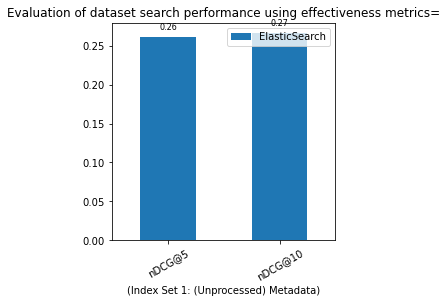

In [216]:
import matplotlib
# matplotlib.style.use('seaborn-whitegrid') 
ax = result_df1.transpose().plot.bar(rot=30, title='Evaluation of dataset search performance using effectiveness metrics=',
                          xlabel='(Index Set 1: (Unprocessed) Metadata)', 
                                     figsize=(4,4), width=0.5)
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

# plt.savefig('IRplot1.png', dpi=300, bbox_inches = 'tight')